1/1 [==============================] - 0s 185ms/step

Predicted Emotion: NEUTRAL (ID: 1)

Class Probabilities:
Class 0: Emotion ID 5 →      angry → 0.04%
Class 1: Emotion ID 2 →       calm → 0.84%
Class 2: Emotion ID 7 →    disgust → 0.06%
Class 3: Emotion ID 6 →    fearful → 4.60%
Class 4: Emotion ID 3 →      happy → 3.99%
Class 5: Emotion ID 1 →    neutral → 77.60%
Class 6: Emotion ID 4 →        sad → 12.84%
Class 7: Emotion ID 8 →  surprised → 0.04%


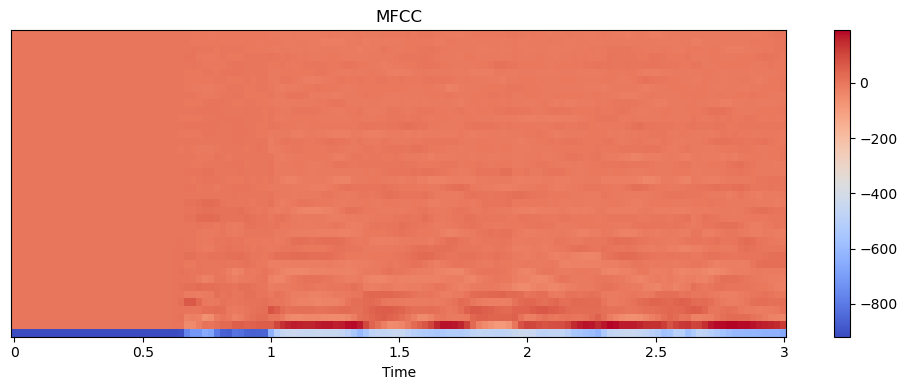

In [48]:
import numpy as np
import librosa
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import librosa.display
import warnings
warnings.filterwarnings("ignore")


SAMPLE_RATE = 22050
DURATION = 3
MAX_PAD_LEN = 130
N_MFCC = 40
MODEL_PATH = "cnn_emotion_model.h5"
ENCODER_PATH = "label_encoder.pkl"

# Emotion ID to Label
emotion_map = {
    1: "neutral", 2: "calm", 3: "happy", 4: "sad",
    5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
}

# Get index → (ID, label) mapping from encoder
def get_index_to_emotion(le):
    label_to_id = {v: k for k, v in emotion_map.items()}
    index_to_label = {i: label for i, label in enumerate(le.classes_)}
    return {
        i: (label_to_id[label], label)
        for i, label in index_to_label.items()
    }
# Load trained model and encoder
model = load_model(MODEL_PATH)
le = joblib.load(ENCODER_PATH)
index_to_emotion = get_index_to_emotion(le)
def extract_mfcc_for_test(file_path, sr=SAMPLE_RATE, duration=DURATION, max_pad_len=MAX_PAD_LEN):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    mfcc_norm = mfcc / np.max(np.abs(mfcc)) 

    if mfcc_norm.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc_norm.shape[1]
        mfcc_norm = np.pad(mfcc_norm, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc_norm = mfcc_norm[:, :max_pad_len]

    return mfcc_norm
def predict_emotion(audio_path):
    mfcc_norm = extract_mfcc_for_test(audio_path)
    input_tensor = np.expand_dims(mfcc_norm, axis=-1)  
    input_tensor = np.expand_dims(input_tensor, axis=0)  

    prediction = model.predict(input_tensor)[0]
    predicted_index = np.argmax(prediction)
    emotion_id, emotion_name = index_to_emotion[predicted_index]

    print(f"\nPredicted Emotion: {emotion_name.upper()} (ID: {emotion_id})")
    print("\nClass Probabilities:")
    for i, prob in enumerate(prediction):
        eid, label = index_to_emotion[i]
        print(f"Class {i}: Emotion ID {eid} → {label:>10} → {prob*100:.2f}%")

    # Plot MFCC heatmap
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

test_file = "../data/Audio_Speech_Actors_01_24/Actor_01/03-01-01-01-01-01-01.wav"
predict_emotion(test_file)
